In [19]:
import numpy as np
import pandas as pd
import torch
import random

from transformers import pipeline
from transformers import AutoTokenizer, AutoModel


import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [20]:
random.seed(65432)

In [21]:
df = pd.read_excel(r"software_600.xlsx") ## Reading in data
df = df[['full_text', 'YN_INNOVATION']].reset_index(inplace=False, drop = True)


In [22]:
## Balancing target class 

df_yes = df[df.YN_INNOVATION == 'yes']
df_no = df[df.YN_INNOVATION == 'no']

if len(df_yes) == len(df_no):
    df_yes = df_yes.append(df_no)
    df = df_yes
    
elif len(df_yes) > len(df_no):
    df_yes = df_yes.sample(n=len(df_no), random_state = 65432)
    df_yes = df_yes.append(df_no)
    df = df_yes
    
elif len(df_no) > len(df_yes):
    df_no = df_no.sample(n=len(df_yes), random_state = 65432)
    df_yes = df_yes.append(df_no)
    df = df_yes
    
df = df.sample(n=len(df), random_state = 65432).reset_index(inplace=False, drop = True)

    
print("Value counts for target variable:\n",df.YN_INNOVATION.value_counts())

## Encoding target variable

le = preprocessing.LabelEncoder()
df.YN_INNOVATION = le.fit_transform(df.YN_INNOVATION)
print("\n\n\nThe target variable classes are:", le.classes_)

Value counts for target variable:
 no     222
yes    222
Name: YN_INNOVATION, dtype: int64



The target variable classes are: ['no' 'yes']


In [23]:
## BERT models:

#uncased
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

#cased
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-cased')

#distil uncased
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

#distil cased
#model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-cased')


# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [24]:
##Big Bird 

#a method using AutoModel and AutoTokenizer
#model_class, tokenizer_class, pretrained_weights = (AutoModel, AutoTokenizer, 'google/bigbird-roberta-base')
#tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
#model = model_class.from_pretrained(pretrained_weights)


# a method using "BigBirdModel" from transformers
#from transformers import BigBirdModel 
#model = BigBirdModel.from_pretrained("google/bigbird-roberta-base")

In [25]:
tokenized = df['full_text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, padding=True, 
                                                              truncation=True,max_length=512)))

In [26]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [27]:
np.array(padded).shape

(444, 512)

In [28]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(444, 512)

In [29]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [30]:
features = last_hidden_states[0][:,0,:].numpy()

In [33]:
labels = df['YN_INNOVATION']

In [34]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [35]:
lr_clf = LogisticRegression(solver="sag")
lr_clf.fit(train_features, train_labels)

/home/asr8r/.conda/envs/akbert/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(solver='sag')

In [36]:
lr_clf.score(test_features, test_labels)

0.8828828828828829

In [37]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


#Create test splits and logistic regression
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

lgr = LogisticRegression(solver="sag")
lgr.fit(train_features, train_labels)

# Save predicted values and predicted value probabilities (prob of being classed "+")
pred = lgr.predict(test_features)
pred_prob = lgr.predict_proba(test_features)[:, 1]


print("Test accuracy:")
print(lgr.score(test_features,test_labels))
print("Vector with coefficient values for theta_1, theta_2")
print("theta_0:",lgr.intercept_[0],"theta_1, theta_2: = ",lgr.coef_[0])

Test accuracy:
0.9009009009009009
Vector with coefficient values for theta_1, theta_2
theta_0: -0.11379806 theta_1, theta_2: =  [ 2.90067434e-01 -5.22598065e-02  1.89446174e-02 -1.68207303e-01
 -2.17840746e-02 -5.98741472e-02  2.06536964e-01 -8.05478543e-02
 -1.24714904e-01 -1.44916594e-01 -4.30659711e-01  1.97025627e-01
 -9.29361582e-02 -1.12228133e-01  8.68236423e-02  1.78494817e-03
 -1.05063073e-01  1.05802700e-01  2.01799169e-01 -2.48026222e-01
  5.52546866e-02 -8.81617740e-02 -8.52799788e-02  1.12681046e-01
 -3.58661681e-01 -2.00532049e-01  1.93390921e-01 -2.40592614e-01
 -7.97923058e-02  3.00484359e-01 -2.94128191e-02  4.45038900e-02
 -1.20400071e-01 -4.91468646e-02 -1.81343526e-01  2.36204550e-01
 -1.20625816e-01  8.53014961e-02 -1.54681623e-01  2.01322958e-01
 -3.17878127e-01  1.51157543e-01  3.08597147e-01 -8.07208940e-02
  1.39501709e-02  1.35797605e-01  2.72044558e-02 -7.10011786e-03
 -3.47901583e-01 -4.93590236e-02  1.68863740e-02  3.57018560e-01
  4.48111519e-02 -2.5628587

/home/asr8r/.conda/envs/akbert/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Text(0.5, 1.0, 'Innovation Data ROC Curve; AUC=0.9314')

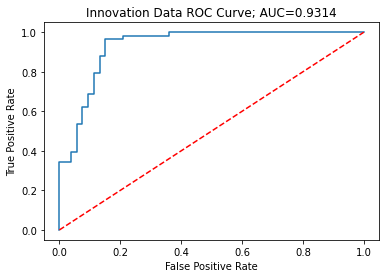

In [40]:
# ROC Graph
fpr, tpr, thresholds = roc_curve(test_labels, pred_prob)
auc = roc_auc_score(test_labels, pred_prob)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color="red")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Innovation Data ROC Curve; AUC={}".format(round(auc, 4)))

Accuracy: 0.9009009009009009
Precision: 0.873015873015873
Recall: 0.9482758620689655
F1: 0.9090909090909091
[[45  8]
 [ 3 55]]


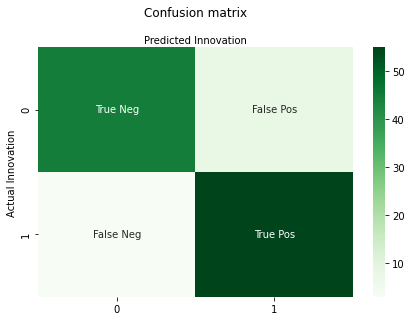

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm, datasets
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

from sklearn import metrics
cm = metrics.confusion_matrix(test_labels, pred)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
labels = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(pd.DataFrame(cm), annot=labels, cmap="Greens" ,fmt='')

ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Innovation')
plt.xlabel('Predicted Innovation')

print("Accuracy:",metrics.accuracy_score(test_labels, pred))
print("Precision:",metrics.precision_score(test_labels, pred))
print("Recall:",metrics.recall_score(test_labels, pred))
print("F1:", metrics.f1_score(test_labels, pred))
print(cm)

Text(0.5, 15.0, 'Predicted Innovation')

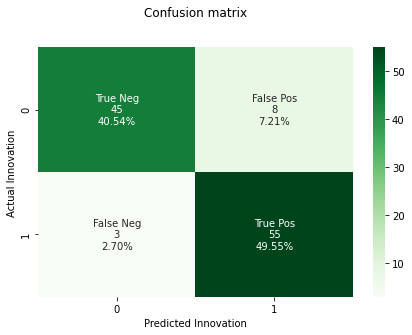

In [44]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Greens')

ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Innovation')
plt.xlabel('Predicted Innovation')

In [45]:
print(df.loc[[26]])

                                            full_text  YN_INNOVATION
26  DJ Synacor Files 8K - Regulation FD >SYNC Syna...              0
